In [1]:
import simtk
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
from gst.gst import grestIntegrator, SimulatedSoluteTempering
import numpy as np

In [2]:
def setup_system(filename):
  """Creates a 'system' object given a pdb filename"""
  pdb = PDBFile(filename)
  forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
  system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds) 
  #barostat = MonteCarloBarostat(1*bar, 310*kelvin)
  #system.addForce(barostat)
  set_dihedral_force_group(system)
  print('Created system')
  return system, pdb

def setup_system_vacuum(filename):
  """Creates a 'system' object given a pdb filename"""
  pdb = PDBFile(filename)
  forcefield = ForceField('amber99sb.xml', 'tip3p.xml')
  system = forcefield.createSystem(pdb.topology, constraints=AllBonds, hydrogenMass=3*amu)
  #barostat = MonteCarloBarostat(1*bar, 310*kelvin)
  #system.addForce(barostat)
  set_dihedral_force_group(system)
  print('Created system')
  return system, pdb

def setup_system_implicit(filename):
  """Creates a 'system' object given a pdb filename"""
  pdb = PDBFile(filename)
  forcefield = app.ForceField('amber99sbildn.xml', 'amber99_obc.xml')
  system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.CutoffNonPeriodic, constraints=HBonds,)
  #barostat = MonteCarloBarostat(1*bar, 310*kelvin)
  #system.addForce(barostat)
  set_dihedral_force_group(system)
  print('Created system')
  return system, pdb


def set_dihedral_force_group(system, g=2):
  """Sets the dihedral forcegroup to a number other than 0,
  which will be used by serial tempering"""
  print('Scanning forces:')
  for f in system.getForces():
    if isinstance(f, simtk.openmm.openmm.PeriodicTorsionForce):
      print('Found the torsions - setting group to 2')
      f.setForceGroup(2)
    print(f.getForceGroup(), f.__class__)

def setup_simulation(system, pdb, integrator):
  platform = Platform.getPlatformByName('CPU')
  prop = {'CPUPrecision':'single'}
  simulation = Simulation(pdb.topology, system, integrator, platform)
  simulation.context.setPositions(pdb.positions)
  simulation.context.setPeriodicBoxVectors(Vec3(2.846979248047194, 0.0, 0.0), 
                                           Vec3(-1.423489624023597, 2.8460968399199644, 0.0), 
                                           Vec3(0.0, 0.0, 2.767338609857905))
  simulation.minimizeEnergy()
  simulation.context.setVelocitiesToTemperature(310*kelvin)
  print('Created simulation')
  return simulation

# Comparing the gREST integrator at differenct scalings.

First try scaling=0.1

In [3]:
# #system, pdb = setup_system('./dialanine/alanine-dipeptide-explicit.pdb')
# system, pdb = setup_system_implicit('./dialanine/alanine-dipeptide-implicit.pdb')
# integrator = grestIntegrator(310*kelvin, 1/picosecond, 0.004*picoseconds, 2, 1)
# simulation = setup_simulation(system, pdb, integrator)

# simulation.reporters.append(DCDReporter('./dialanine/diala_normal_traj.dcd', 500))

# one_ns = int(2.5e5)
# number_ns = 100
# number_steps = number_ns*one_ns
# simulation.reporters.append(StateDataReporter(stdout, 500, step=True,
#         potentialEnergy=True, density=True, speed=True))

    
# simulation.step(number_steps)

Scaling 0.2:

In [4]:
# from tqdm import tqdm_notebook

# system, pdb = setup_system_implicit('./dialanine/alanine-dipeptide-implicit.pdb')
# integrator = grestIntegrator(310*kelvin, 1/picosecond, 0.002*picoseconds, 2, 0.01)
# simulation = setup_simulation(system, pdb, integrator)
# simulation.reporters.append(DCDReporter('./dialanine/diala_scaled-low_traj.dcd', 500))

# simulation.reporters.append(StateDataReporter(stdout, 500, step=True,
#         potentialEnergy=True, density=True, speed=True))

# for _ in tqdm_notebook(range(2000)):
#     simulation.step(500)

# Running actual GST:

In [19]:
from tqdm import tqdm_notebook
#system, pdb = setup_system('./dialanine/alanine-dipeptide-explicit.pdb')
system, pdb = setup_system_implicit('./dialanine/alanine-dipeptide-implicit.pdb')
integrator = grestIntegrator(310*kelvin, 1/picosecond, 0.002*picoseconds, 2, 1)
simulation = setup_simulation(system, pdb, integrator)


##The simulated tempering object:
st = SimulatedSoluteTempering(simulation,
                              forceGroup=2,
                              cutoff=1e-8,
                              numTemperatures=15,
                              tempChangeInterval=50,
                              minTemperature=310*kelvin,
                              maxTemperature=1500*kelvin,
                              reportInterval=500,
                              #reportFile=stdout,
                              reportFile='./dialanine/diala_gst_temp3.dat',
                             )
                              #reportFile='./dialanine/diala_gst_temp2.dat')


for _ in tqdm_notebook(range(2000)):
   simulation.step(500)
   print(st._weightUpdateFactor)
   if st._weightUpdateFactor<st.cutoff:
        break
   #print(st._weightUpdateFactor)

Scanning forces:
0 <class 'simtk.openmm.openmm.HarmonicBondForce'>
0 <class 'simtk.openmm.openmm.HarmonicAngleForce'>
Found the torsions - setting group to 2
2 <class 'simtk.openmm.openmm.PeriodicTorsionForce'>
0 <class 'simtk.openmm.openmm.NonbondedForce'>
0 <class 'simtk.openmm.openmm.GBSAOBCForce'>
0 <class 'simtk.openmm.openmm.CMMotionRemover'>
Created system
Created simulation
1e-08


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.25
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.125
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0625
0.0

3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
3.0517578125e-05
1.52587890625e-05
1.52587890625e-05
1.52587890625e-05
1.52587890625e-05
1.52587890625e-05
1.52587890625e-05
1.52587890625e-05
1.52587890625e-05
1.5258

1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
1.1920928955078125e-07
5.960464477539063e-08
5.960464477539063e-08
5.960464477539063e-08
5.960464477539063e-08
5.960464477539063e-08
5.960464477539063e-08
5.960464477539063e-08
5.960464477539063e-08
5.960464477539063e-

In [14]:
#Now, remove the simulated tempering (which is just a reporter)
#and add the DCD reporter, and the state reporter.
simulation.reporters.pop(0)
import numpy as np
weights_store = np.array(st.weights).copy()
#    def set_weights(self, newWeights):
#        self._weights = newWeights


In [8]:
##The simulated tempering object:
st = SimulatedSoluteTempering(simulation,
                              forceGroup=2,
                              cutoff=0.0000000001,
                              numTemperatures=20,
                              tempChangeInterval=500,
                              minTemperature=310*kelvin,
                              maxTemperature=1500*kelvin,
                              reportInterval=500,
                              reportFile='./dialanine/diala_gst_temp3.dat',
                             )

st._weights = list(weights_store)
st._updateWeights = False


simulation.reporters.append(DCDReporter('./dialanine/diala_gst_traj.dcd', 500))
simulation.reporters.append(StateDataReporter(stdout, 500, step=True,
        potentialEnergy=True, density=True, speed=True))

In [12]:
for _ in tqdm_notebook(range(2000)):
   simulation.step(500)

#"Step","Potential Energy (kJ/mole)","Density (g/mL)","Speed (ns/day)"
102500,-90.36367038565129,0.010676642612682098,0
103000,-50.319787809836555,0.010676642612682098,317
103500,-40.128176196762325,0.010676642612682098,306
104000,-50.11631227828099,0.010676642612682098,292
104500,-90.93872087155935,0.010676642612682098,288
105000,-64.17865141844467,0.010676642612682098,276
105500,-81.14833778969154,0.010676642612682098,276
106000,-65.43879486773807,0.010676642612682098,275
106500,-109.610239531541,0.010676642612682098,279
107000,-66.63357573301454,0.010676642612682098,282
107500,-80.50903717147673,0.010676642612682098,285
108000,-37.53609506687337,0.010676642612682098,287
108500,-93.01840223103315,0.010676642612682098,289
109000,-98.16809518927775,0.010676642612682098,291
109500,-73.77081617892107,0.010676642612682098,294
110000,-114.11901988028319,0.010676642612682098,296
110500,-82.39405475501437,0.010676642612682098,297
111000,-100.51947559028923,0.010676642612682098,296
111500,-85

182000,-59.663566671102046,0.010676642612682098,319
182500,-91.8949612143985,0.010676642612682098,319
183000,-65.62587807167793,0.010676642612682098,319
183500,-102.86430783692646,0.010676642612682098,319
184000,-71.9444430675166,0.010676642612682098,318
184500,-96.06127847154667,0.010676642612682098,318
185000,-116.77552814744556,0.010676642612682098,318
185500,-84.84412657851237,0.010676642612682098,318
186000,-36.596628944000145,0.010676642612682098,317
186500,-32.39075514972379,0.010676642612682098,317
187000,-36.66015818943379,0.010676642612682098,317
187500,-96.25315110132107,0.010676642612682098,317
188000,-78.40503572635336,0.010676642612682098,318
188500,-13.985464124929308,0.010676642612682098,319
189000,-39.827018573677265,0.010676642612682098,318
189500,-72.89014533461248,0.010676642612682098,318
190000,-87.4578702077863,0.010676642612682098,318
190500,-77.43103129516894,0.010676642612682098,318
191000,-96.61035749068233,0.010676642612682098,318
191500,-84.32256625780045,0.

262500,-80.71807798188988,0.010676642612682098,318
263000,-71.57250576801732,0.010676642612682098,318
263500,-10.67381500809904,0.010676642612682098,318
264000,-96.42277470276179,0.010676642612682098,318
264500,-79.83335251946559,0.010676642612682098,318
265000,-57.57744470105533,0.010676642612682098,318
265500,-94.78468664228242,0.010676642612682098,318
266000,-104.41574235461748,0.010676642612682098,319
266500,-105.50312235465415,0.010676642612682098,319
267000,-81.8857934680684,0.010676642612682098,319
267500,-71.40393271881277,0.010676642612682098,319
268000,-83.05444983486532,0.010676642612682098,319
268500,-117.82087501745008,0.010676642612682098,319
269000,-89.52757453504347,0.010676642612682098,319
269500,-89.08159111715435,0.010676642612682098,319
270000,-118.05277072918066,0.010676642612682098,319
270500,-86.70995024007773,0.010676642612682098,319
271000,-88.40255495038134,0.010676642612682098,319
271500,-76.23904642987776,0.010676642612682098,319
272000,-62.282506468127394,0

343000,-108.69679225758748,0.010676642612682098,319
343500,-39.81684892479137,0.010676642612682098,319
344000,-81.3007562179558,0.010676642612682098,319
344500,-56.644612848496024,0.010676642612682098,319
345000,-101.30737293119245,0.010676642612682098,319
345500,-71.70497982390498,0.010676642612682098,319
346000,-48.73677697313735,0.010676642612682098,319
346500,-35.65385960838685,0.010676642612682098,319
347000,-73.41431352179032,0.010676642612682098,319
347500,-118.57883784246711,0.010676642612682098,319
348000,-71.18153892375216,0.010676642612682098,318
348500,-77.33066282814269,0.010676642612682098,318
349000,-91.18006178757898,0.010676642612682098,318
349500,-55.97145077010137,0.010676642612682098,318
350000,-86.62966184029656,0.010676642612682098,318
350500,-100.94272426699717,0.010676642612682098,318
351000,-86.78219106929231,0.010676642612682098,318
351500,-85.97806068686319,0.010676642612682098,318
352000,-33.444111571926214,0.010676642612682098,318
352500,-100.17112840374737

423500,-94.47955650857138,0.010676642612682098,312
424000,-31.15428004303635,0.010676642612682098,312
424500,-45.17704074882485,0.010676642612682098,312
425000,-74.48797598533477,0.010676642612682098,312
425500,-42.591305235984976,0.010676642612682098,312
426000,-65.86816809584101,0.010676642612682098,312
426500,40.631784580529256,0.010676642612682098,312
427000,-64.74124344342408,0.010676642612682098,312
427500,-62.025460132469505,0.010676642612682098,312
428000,-57.098781981928454,0.010676642612682098,312
428500,-60.06199544992933,0.010676642612682098,312
429000,-47.24792734359181,0.010676642612682098,312
429500,-81.44233334193416,0.010676642612682098,312
430000,-50.07610196653968,0.010676642612682098,312
430500,-11.260571990119843,0.010676642612682098,312
431000,-62.33381571472103,0.010676642612682098,312
431500,-37.10462466626734,0.010676642612682098,312
432000,-76.22138376855847,0.010676642612682098,312
432500,-59.49213630249346,0.010676642612682098,313
433000,-88.19974978480403,0

KeyboardInterrupt: 

In [6]:
headers = ['Steps', 'Temperature (K)']
for t in st.temperatures:
    headers.append('%gK Weight' % t.value_in_unit(kelvin))

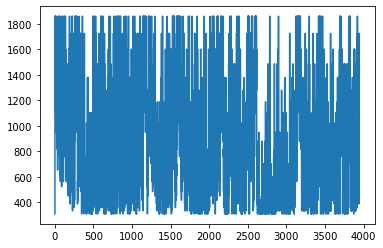

In [4]:
import matplotlib.pyplot as plt
plt.plot(temps)

In [5]:
st.weights

[0.0, -0.25, -0.75, -1.75, -2.125]

In [25]:
st.temperatures[st.currentTemperature].value_in_unit(kelvin)

310.0

In [8]:
simulation.context.getState(getEnergy=True,groups={2}).getPotentialEnergy().value_in_unit(kelvin)

TypeError: Unit "kilojoule/mole" is not compatible with Unit "kelvin".

In [9]:
st._weightUpdateFactor

7.450580596923828e-09

In [10]:
st.temperatures

Quantity(value=[310.0, 352.3253775630145, 400.42958604813145, 455.1016293284178, 517.2382367183159, 587.8585711026082, 668.1209452173568, 759.3418202627852, 863.0173984628146, 980.8481637318121, 1114.7667729638715, 1266.969755416772, 1439.9535401230141, 1636.5554022485176, 1860.0], unit=kelvin)

In [8]:
st.inverseTemperatures

[Quantity(value=0.002405444250279036, unit=mole/joule),
 Quantity(value=0.002111523355696405, unit=mole/joule),
 Quantity(value=0.0018535166138787915, unit=mole/joule),
 Quantity(value=0.0016270356795516593, unit=mole/joule),
 Quantity(value=0.0014282284187322875, unit=mole/joule),
 Quantity(value=0.0012537133891474467, unit=mole/joule),
 Quantity(value=0.001100522326479628, unit=mole/joule),
 Quantity(value=0.0009660496582107511, unit=mole/joule),
 Quantity(value=0.0008480081863622093, unit=mole/joule),
 Quantity(value=0.0007443901853546774, unit=mole/joule),
 Quantity(value=0.0006534332533149524, unit=mole/joule),
 Quantity(value=0.0005735903360068126, unit=mole/joule),
 Quantity(value=0.000503503413533545, unit=mole/joule),
 Quantity(value=0.00044198040225859185, unit=mole/joule),
 Quantity(value=0.0003879748790772639, unit=mole/joule)]

In [9]:
st.scalingFactors

[1.0,
 0.8778101406638149,
 0.7705506430522263,
 0.6763971683662676,
 0.5937482935081994,
 0.5211982730433323,
 0.45751312937390487,
 0.4016096644512495,
 0.3525370360438987,
 0.3094605851988991,
 0.27164763982335194,
 0.23845505292432992,
 0.20931826354950345,
 0.18374169436989501,
 0.16129032258064518]